# Chapter 7

In [1]:
using ControlSystems
using Plots; gr()
using LinearAlgebra

## オブザーバ

In [2]:
A = [0 1; -4 -5]
B = [0; 1]
C = [1 0]
D = 0
P = ss(A, B, C, D)
println(P)

StateSpace{Continuous, Int64}
A = 
  0   1
 -4  -5
B = 
 0
 1
C = 
 1  0
D = 
 0

Continuous-time state-space model


### オブザーバゲインの設計（極配置）

In [3]:
# オブザーバ極
observer_poles=[-10+5im,-10-5im]

# オブザーバゲインの設計（状態フィードバックの双対）
L = -place(P.A', P.C', observer_poles)'
println(L)

ComplexF64[-15.0 + 0.0im; -46.0 + 0.0im;;]


In [4]:
L = [ convert(Float64, L[i]) for i in 1:length(L) ]

2-element Vector{Float64}:
 -15.0
 -46.0

In [5]:
eigvals(P.A + L * P.C)

2-element Vector{ComplexF64}:
 -10.0 - 5.0im
 -10.0 + 5.0im

In [6]:
G = ss(P.A, P.B, [1 0; 0 1], [0; 0]);
Obs = ss(P.A + L*P.C, [P.B -L], [1 0; 0 1], [0 0; 0 0]);

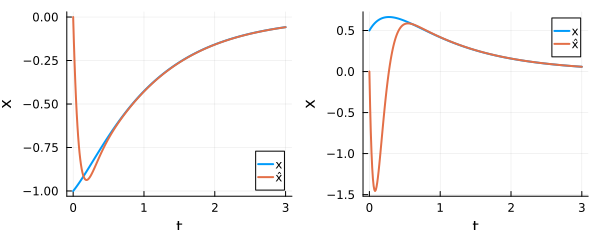

In [7]:
Td = 0:0.01:3;
X0 = [-1, 0.5];
# u(x,t) = [0];
Ud = zeros(1, length(Td))
y, t, x, uout = lsim(G, Ud, Td, x0=X0);

y, t, xhat, uout = lsim(Obs, [Ud' y[1,:]]', Td, [0, 0]);

p = [ plot(), plot()]

for i=1:2
plot!(p[i], t, x[i,:],
    xlabel="t",   #X軸のラベル
    ylabel="x",   #Y軸のラベル
    lw=2,           #線幅
    ls=:solid,        #線種
    label="x",
    size=(300,230)   #プロットのサイズ
)

plot!(p[i], t, xhat[i,:],
    xlabel="t",   #X軸のラベル
    ylabel="x",   #Y軸のラベル
    lw=2,           #線幅
    ls=:solid,        #線種
    label="x̂",
    size=(300,230)   #プロットのサイズ
)
end

plot( p[1], p[2], layout=(1,2), size=(600,230) )

### 出力フィードバック

In [8]:
# レギュレータ極
regulator_poles = [-5 + 2im, -5 - 2im]
# 極配置
F = -place(P.A, P.B, regulator_poles)
F = [convert(Float64, F[i]) for i in 1:length(F)]'
print(F)

[-25.0 -5.0]

In [9]:
# 出力フィードバック（オブザーバ＋状態フィードバック）
K = ss(P.A+P.B*F+L*P.C, -L, F, 0)
println("K:\n", K)
println("----------------")
println("K(s)=\n", tf(K))

# フィードバック系
Gfb = feedback(P, -K);

K:
StateSpace{Continuous, Float64}
A = 
 -15.0    1.0
 -75.0  -10.0
B = 
 15.0
 46.0
C = 
 -25.0  -5.0
D = 
 0.0

Continuous-time state-space model
----------------
K(s)=
TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
   -605.0s - 2725.0
----------------------
1.0s^2 + 25.0s + 225.0

Continuous-time transfer function model


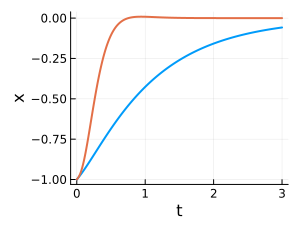

In [10]:
Td = 0:0.01:3;

# u(x,t) = [0];
yorg, t, x, uout = lsim(P, Ud, Td, [-1, 0.5])
y, t, x, uout = lsim(Gfb, Ud, Td, [-1, 0.5, 0, 0])

plot(t, yorg',
    xlabel="t",   #X軸のラベル
    ylabel="x",   #Y軸のラベル
    lw=2,           #線幅
    ls=:solid,        #線種
    legend=false,
    size=(300, 230)   #プロットのサイズ
)
plot!(t, y',
    xlabel="t",   #X軸のラベル
    ylabel="x",   #Y軸のラベル
    lw=2,           #線幅
    ls=:solid,        #線種
    legend=false,
    size=(300,230)   #プロットのサイズ
)


### 外乱オブザーバ

In [11]:
using ControlSystems
using Plots; gr()
using LinearAlgebra

In [12]:
A = [0 1; -4 -5]
B = [0; 1]
C = [1 0]
D = 0
P = ss(A, B, C, D)
println(P)

A = [0 1; -4 -5]
B = [0; 1]
C = [1 0; 0 1]
D = [0; 0]
Ps = ss(A, B, C, D)
println(Ps)

StateSpace{Continuous, Int64}
A = 
  0   1
 -4  -5
B = 
 0
 1
C = 
 1  0
D = 
 0

Continuous-time state-space model
StateSpace{Continuous, Int64}
A = 
  0   1
 -4  -5
B = 
 0
 1
C = 
 1  0
 0  1
D = 
 0
 0

Continuous-time state-space model


出力に0.5の定値外乱が加わるとする

In [13]:
# オブザーバ極
observer_poles=[-15+5im,-15-5im]
# オブザーバゲインの設計（状態フィードバックの双対）
L = -place(P.A', P.C', observer_poles)'
L = [ convert(Float64, L[i]) for i in 1:length(L) ]

G = ss(P.A , P.B, [1 0; 0 1], [0; 0]);
Obs = ss(P.A + L*P.C, [P.B -L], [1 0; 0 1], [0 0; 0 0]);

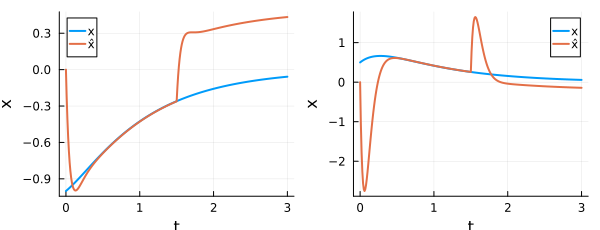

In [14]:
Td = 0:0.01:3;
Ud = zeros(1, length(Td))
d = zeros(1, length(Td))
d[151:length(Td)] .= 0.5
X0 = [-1, 0.5];

y, t, x, uout = lsim(G, Ud, Td, x0=X0);

y, t, xhat, uout = lsim(Obs, [Ud' y[1,:]+d']', Td, [0, 0]);

p = [ plot(), plot()]

for i=1:2
plot!(p[i], t, x[i,:],
    xlabel="t",   #X軸のラベル
    ylabel="x",   #Y軸のラベル
    lw=2,           #線幅
    ls=:solid,        #線種
    label="x",
    size=(300,230)   #プロットのサイズ
)

plot!(p[i], t, xhat[i,:],
    xlabel="t",   #X軸のラベル
    ylabel="x",   #Y軸のラベル
    lw=2,           #線幅
    ls=:solid,        #線種
    label="x̂",
    size=(300,230)   #プロットのサイズ
)
end

plot( p[1], p[2], layout=(1,2), size=(600,230) )

In [15]:
# オブザーバ極
observer_poles=[-10+5im,-10-5im, -3]

# オブザーバゲインの設計（状態フィードバックの双対）
Abar = [ P.A zeros(2,1) ; 0 0 0 ]
Bbar = [ P.B; 0 ]
Cbar = [ P.C 1 ]

Lbar = -place(Abar', Cbar', observer_poles)'
Lbar = [ convert(Float64, Lbar[i]) for i in 1:length(Lbar) ]

println(Lbar)

[75.75, -91.0, -93.75]


In [16]:
Aob = Abar + Lbar*Cbar
Bob = [Bbar -Lbar]
Obs = ss(Aob, Bob, [1 0 0; 0 1 0; 0 0 1], [0 0; 0 0; 0 0] );

In [17]:
pole(Obs)

3-element Vector{ComplexF64}:
  -9.999999999999982 + 5.000000000000019im
  -9.999999999999982 - 5.000000000000019im
 -3.0000000000000466 + 0.0im

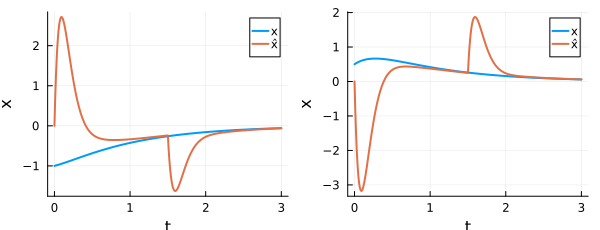

In [18]:
Td = 0:0.01:3;
Ud = zeros(1, length(Td))
d = zeros(1, length(Td))
d[151:length(Td)] .= 0.5
X0 = [-1, 0.5];

y, t, x, uout = lsim(G, Ud, Td, x0=X0);

y, t, xhat, uout = lsim(Obs, [Ud' y[1,:]+d']', Td, [0, 0, 0]);

p = [ plot(), plot()]

for i=1:2
plot!(p[i], t, x[i,:],
    xlabel="t",   #X軸のラベル
    ylabel="x",   #Y軸のラベル
    lw=2,           #線幅
    ls=:solid,        #線種
    label="x",
    size=(300,230)   #プロットのサイズ
)

plot!(p[i], t, xhat[i,:],
    xlabel="t",   #X軸のラベル
    ylabel="x",   #Y軸のラベル
    lw=2,           #線幅
    ls=:solid,        #線種
    label="x̂",
    size=(300,230)   #プロットのサイズ
)
end

plot( p[1], p[2], layout=(1,2), size=(600,230) )

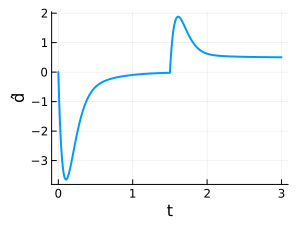

In [19]:
plot(t, xhat[3,:],
    xlabel="t",   #X軸のラベル
    ylabel="d̂",   #Y軸のラベル
    lw=2,           #線幅
    ls=:solid,        #線種
    legend=false,
    size=(300,230)   #プロットのサイズ
)

外乱 0.5 が推定できている

## ロバスト制御

In [20]:
using ControlSystems
using RobustAndOptimalControl
using Plots; gr()
using LinearAlgebra

In [21]:
g  = 9.81                # 重力加速度[m/s^2]
l  = 0.2                 # アームの長さ[m]
M  = 0.5                 # アームの質量[kg]
mu = 1.5e-2              # 粘性摩擦係数
J  = 1.0e-2              # 慣性モーメント

P = tf( [0,1], [J, mu, M*g*l] )

ref = 30 # 目標角度 [deg]

30

### 乗法的不確かさ

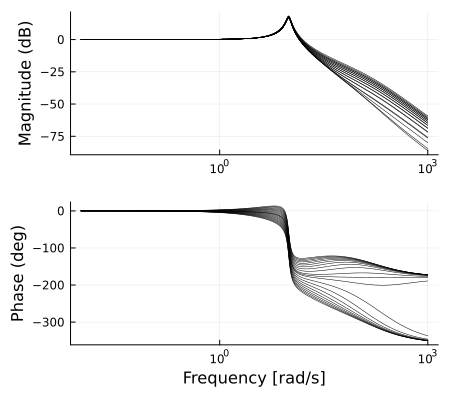

In [22]:
# 垂直駆動アームのノミナルモデル
Pn = tf( [0,1], [J, mu, M*g*l] )

# 不確かさ
delta = LinRange(-1, 1, 20)
WT = tf( [10, 0], [1, 150])

P = TransferFunction[ (1 + WT*delta[i])*Pn for i in 1:length(delta) ];
DT = TransferFunction[ WT*delta[i] for i in 1:length(delta) ];

setPlotScale("dB")
w = exp10.(LinRange(-2, 3, 1000))
bodeplot(Pn, w; lc=:black, lw=0.5, title="")
for sys in P
    bodeplot!(sys, w; lc=:black, lw=0.5, title=""  )
end

plot!(legend=false,
    size=(450, 400)   #プロットのサイズ
)

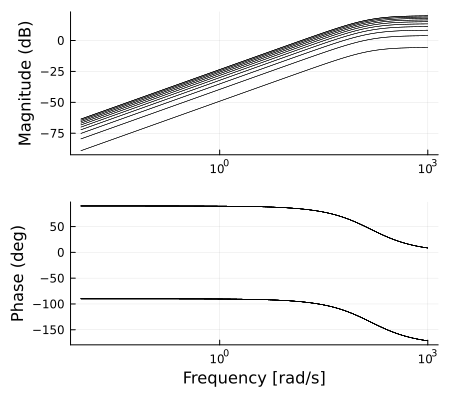

In [23]:
bodeplot(DT[1], w; lc=:black, lw=0.5, title="")
for sys in DT
    bodeplot!(sys, w; lc=:black, lw=0.5, title=""  )
end
plot!(legend=false,
    size=(450, 400)   #プロットのサイズ
)

### 混合感度問題

確認中

In [24]:
WS = tf( [0, 1], [1, 1, 0.25]); # 感度関数に対する重み関数
WU = ss(1.0)
WT = tf( [10, 0], [1, 150]); # 相補感度関数に対する重み関数

G = hinfpartition(Pn, WS, WU, WT)
# Check if the system is feasible for synythesis
flag = hinfassumptions(G, verbose=false)

true

In [25]:
# Synthesize the H-infinity optimal controller
K, γ = hinfsynthesize(G, γrel=1.0);
Pcl, S, CS, T = hinfsignals(G, Pn, K);

println(tf(K))
println(γ)

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
     6.914688563198183s^4 + 1053.488413717986s^3 + 3129.9699783801843s^2 + 103660.1636521904s + 87011.21342993349
-----------------------------------------------------------------------------------------------------------------------
1.0s^5 + 164.802459568436s^4 + 2400.3155738379014s^3 + 24135.781867094975s^2 + 22417.633916500767s + 5464.6420344833505

Continuous-time transfer function model
0.9527801586107133


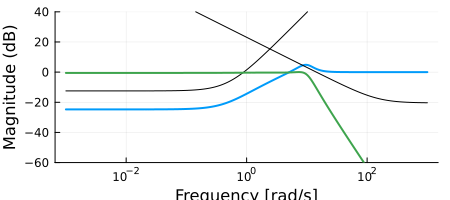

In [26]:
w = exp10.(LinRange(-3, 3, 1000))

# 感度関数
Ssys = feedback(1, Pn * K)
bodeplot(Ssys, w; plotphase=false, lw=2, title="")
bodeplot!(γ / WS, w; plotphase=false, lc=:black, title="")

# 相補感度関数
Tsys = feedback(Pn * K, 1)
bodeplot!(Tsys, w; plotphase=false, lw=2, title="")
bodeplot!(γ / WT, w; plotphase=false, lc=:black, title="")

plot!(legend=false,
    ylims=(-60, 40),
    size=(450, 200)   #プロットのサイズ
)

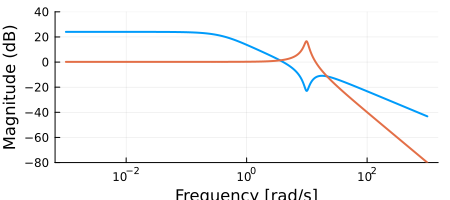

In [27]:
bodeplot(K, w; plotphase=false, lw=2, title="")
bodeplot!(Pn, w; plotphase=false, lw=2, title="")
plot!(legend=false,
    ylims=(-80, 40),
    size=(450, 200)   #プロットのサイズ
)

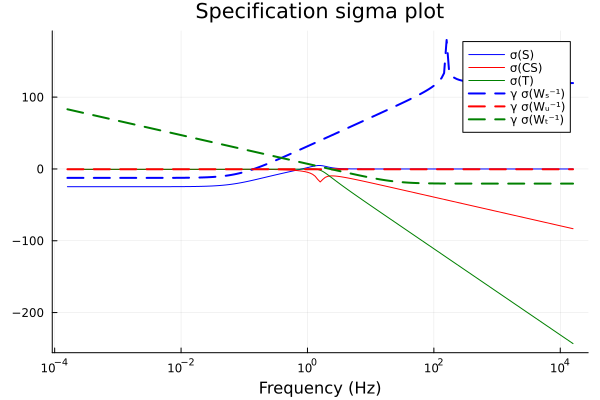

In [28]:
## Plot the specifications
specificationplot([S, CS, T], [WS, WU, WT], γ) |> display

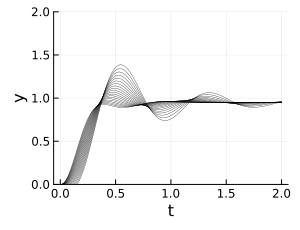

In [29]:
plt = plot()
for i in 1:1:length(delta)
    P = (1 + WT * delta[i]) * Pn
    Gyr = feedback(P * K, 1)
    y, t = step(Gyr, 0:0.01:2)
    plot!(plt, t, y', lc=:black, lw=0.3)
end

plot!(plt,
    xlabel="t",   #X軸のラベル
    ylabel="y",   #Y軸のラベル
    ylim=(0, 2),
    lw=2,           #線幅
    ls=:solid,        #線種
    legend=false,
    size=(300, 230)   #プロットのサイズ
)

┌ Warning: Keyword argument hover not supported with Plots.GRBackend().  Choose from: annotationcolor, annotationfontfamily, annotationfontsize, annotationhalign, annotationrotation, annotations, annotationvalign, arrow, aspect_ratio, axis, background_color, background_color_inside, background_color_outside, background_color_subplot, bar_width, bins, bottom_margin, camera, clims, color_palette, colorbar, colorbar_entry, colorbar_scale, colorbar_title, colorbar_titlefont, colorbar_titlefontcolor, colorbar_titlefontrotation, colorbar_titlefontsize, connections, contour_labels, discrete_values, fill, fill_z, fillalpha, fillcolor, fillrange, fillstyle, flip, fontfamily, fontfamily_subplot, foreground_color, foreground_color_axis, foreground_color_border, foreground_color_grid, foreground_color_subplot, foreground_color_text, formatter, framestyle, grid, gridalpha, gridlinewidth, gridstyle, group, guide, guidefont, guidefontcolor, guidefontfamily, guidefonthalign, guidefontrotation, guidefo

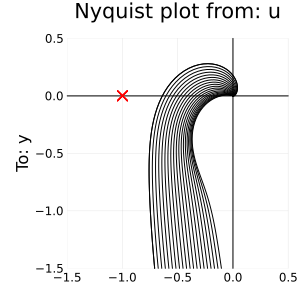

In [30]:
H = TransferFunction[K * (1 + WT * delta[i]) * Pn for i in 1:length(delta)];
nyquistplot(H[1], linecolor=:black, linewidth=1)
for sys in H
    nyquistplot!(sys, linecolor=:black, linewidth=1, legend=false)
end
plot!(xlims=(-1.5, 0.5),
    ylims=(-1.5, 0.5),
    size=(300, 300),   #プロットのサイズ
)

### PID制御との比較

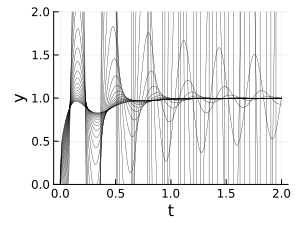

In [31]:
kp = 2
kd = 0.1
ki = 10

plt = plot()
for i in 1:1:length(delta)
    Kpid = tf([kd, kp, ki], [1, 0])

    P = (1 + WT*delta[i])*Pn
    Gyr = feedback(P*Kpid, 1)
    y, t = step(Gyr, 0:0.01:2 )
    plot!(plt, t, y', lc=:black, lw =0.3)
end

plot!(plt,
    xlabel="t",   #X軸のラベル
    ylabel="y",   #Y軸のラベル
    ylim = (0,2),
    lw=2,           #線幅
    ls=:solid,        #線種
    legend=false,
    size=(300,230)   #プロットのサイズ
)

ナイキスト線図で不確かさの影響を確認する

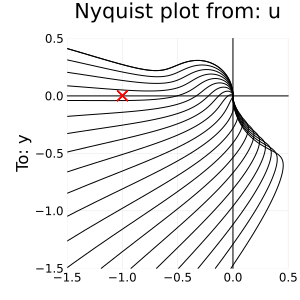

In [32]:
Kpid = tf([kd, kp, ki], [1, 0])
H = TransferFunction[ Kpid*(1 + WT*delta[i])*Pn for i in 1:length(delta) ];
nyquistplot(H[1], linecolor=:black, linewidth=1)
for sys in H
    nyquistplot!(sys, linecolor=:black, linewidth=1, legend=false)
end
plot!(xlims=(-1.5, 0.5),
    ylims=(-1.5, 0.5),
    size=(300, 300),   #プロットのサイズ
)

## ディジタル実装

In [33]:
using ControlSystems
using Plots; gr()
using LinearAlgebra

In [34]:
P = tf([0, 1], [0.5, 1])
println("連続時間システム",P)

連続時間システムTransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
   1.0
----------
0.5s + 1.0

Continuous-time transfer function model


In [35]:
ts = 0.2

Pd1 = c2d(P, ts, :zoh)
println("離散時間システム（zoh）", Pd1)

離散時間システム（zoh）TransferFunction{Discrete{Float64}, ControlSystemsBase.SisoRational{Float64}}
   0.3296799539643608
-------------------------
1.0z - 0.6703200460356393

Sample Time: 0.2 (seconds)
Discrete-time transfer function model


In [36]:
Pd2 = c2d(P, ts, :tustin)
print("離散時間システム（tustin）",Pd2)

離散時間システム（tustin）TransferFunction{Discrete{Float64}, ControlSystemsBase.SisoRational{Float64}}
0.16666666666666669z + 0.1666666666666667
-----------------------------------------
        1.0z - 0.6666666666666667

Sample Time: 0.2 (seconds)
Discrete-time transfer function model

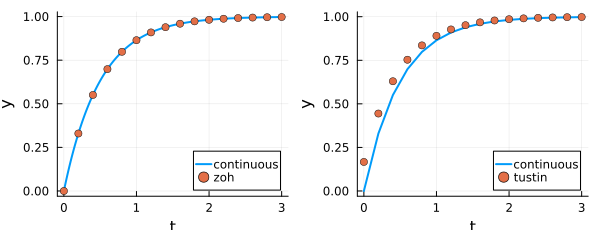

In [37]:
Tc = 0:0.01:3
y, t = step(P, Tc)

Td = 0:ts:3;

p = [ plot(), plot()]

plot!(p[1], t, y',
    xlabel="t",   #X軸のラベル
    ylabel="y",   #Y軸のラベル
    lw=2,           #線幅
    ls=:solid,        #線種
    label="continuous",
    size=(300,230)   #プロットのサイズ
)

y, t = step(Pd1, Td)

plot!(p[1], t, y',
    seriestype = :scatter,
    xlabel="t",   #X軸のラベル
    ylabel="y",   #Y軸のラベル
    label="zoh",
    legend=:bottomright,
    size=(300,230)   #プロットのサイズ
)

plot!(p[2], t, y',
    xlabel="t",   #X軸のラベル
    ylabel="y",   #Y軸のラベル
    lw=2,           #線幅
    ls=:solid,        #線種
    label="continuous",
    size=(300,230)   #プロットのサイズ
)

y, t = step(Pd2, Td)

plot!(p[2], t, y',
    seriestype = :scatter,
    xlabel="t",   #X軸のラベル
    ylabel="y",   #Y軸のラベル
    label="tustin",
    legend=:bottomright,
    size=(300,230)   #プロットのサイズ
)


plot( p[1], p[2], layout=(1,2), size=(600,230) )

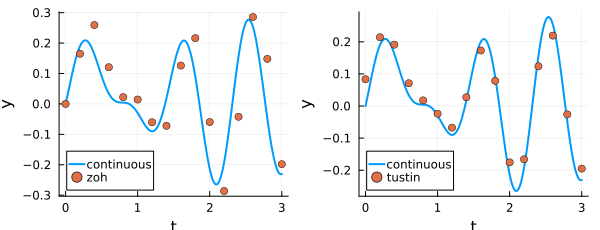

In [38]:
Tc = 0:0.01:3

u(x,t) = [0.5 * sin.(6*t) + 0.5 * cos.(8*t)]
yc, tc, x, uout = lsim(P, u, Tc);

Td = 0:ts:3;

p = [ plot(), plot()]

plot!(p[1], tc, yc',
    xlabel="t",   #X軸のラベル
    ylabel="y",   #Y軸のラベル
    lw=2,           #線幅
    ls=:solid,        #線種
    label="continuous",
    size=(300,230)   #プロットのサイズ
)

y, t, x, uout = lsim(Pd1, u, Td);

plot!(p[1], t, y',
    seriestype = :scatter,
    xlabel="t",   #X軸のラベル
    ylabel="y",   #Y軸のラベル
    label="zoh",
    legend=:bottomleft,
    size=(300,230)   #プロットのサイズ
)

plot!(p[2], tc, yc',
    xlabel="t",   #X軸のラベル
    ylabel="y",   #Y軸のラベル
    lw=2,           #線幅
    ls=:solid,        #線種
    label="continuous",
    size=(300,230)   #プロットのサイズ
)

y, t, x, uout = lsim(Pd2, u, Td);

plot!(p[2], t, y',
    seriestype = :scatter,
    xlabel="t",   #X軸のラベル
    ylabel="y",   #Y軸のラベル
    label="tustin",
    legend=:bottomleft,
    size=(300,230)   #プロットのサイズ
)


plot( p[1], p[2], layout=(1,2), size=(600,230) )

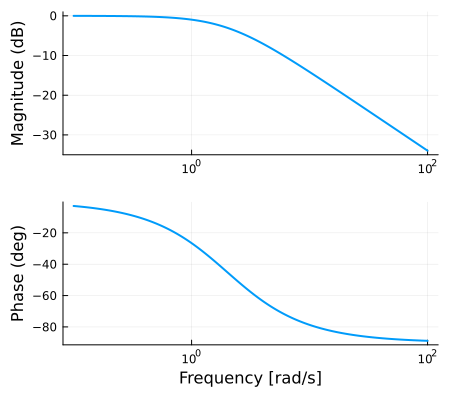

In [39]:
setPlotScale("dB")
bodeplot(P, lw=2, size=(450,400), legend=false, title=""  )

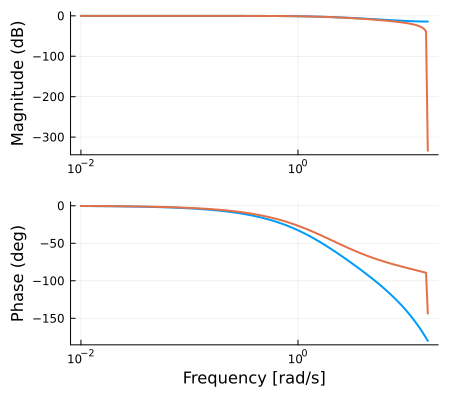

In [40]:
setPlotScale("dB")
bodeplot([Pd1, Pd2], lw=2, size=(450,400), legend=false, title=""  )